In [8]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np
import configs
import seaborn as sns
import pandas as pd
import h5py

In [4]:
exp = 'pnet_pt3'
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
tensorboard_dir = f'{engram_dir}2_hyperp/{exp}/'
activations_dir = f'{engram_dir}3_activations/{exp}/'
plot_ci = True

In [5]:
load_valid_scores = True

# Helper functions

In [13]:
def eval_accuracy(results, timestep=4):
    """ t is the timestep to eval """
    labels = np.array(results['label'])
    timesteps = []
    accuracies = []
    rel_accuracies = []
    ff_corrects = []
    clean_corrects = []
    n_timesteps = 5
    
    for i in range(labels.size):
        label = labels[i]
        ff_acc = None
        for t in range(n_timesteps):
            output = results[f'{t}_output'][i]
            acc_t = (output == label).astype(float)
            if t == 0:
                ff_acc = acc_t
            rel_acc_t = acc_t - ff_acc
            if  t != timestep:
                continue
            timesteps.append(t)
            accuracies.append(acc_t)
            rel_accuracies.append(rel_acc_t)
            ff_corrects.append(ff_acc)
            clean_corrects.append(results['clean_correct'][i])

    timesteps = np.array(timesteps)
    accuracies = np.array(accuracies)
    rel_accuracies = np.array(rel_accuracies)
    ff_corrects = np.array(ff_corrects)
    clean_corrects = np.array(clean_corrects)
            
    return timesteps, accuracies, rel_accuracies, ff_corrects, clean_corrects

# Collect hyperparameter values

In [92]:
feedforward = []
feedback = []
memory = []
error_scaling = []
iteration = []
bg = []
snr = []
layers = []
epochs = []
valid_scores = []

for tfdir in os.listdir(tensorboard_dir):
    if 'hyper' not in tfdir: continue
    noise_info = tfdir.split('_')
    noise_snr = float(noise_info[-1][3:])
    noise_bg = noise_info[1]
    
    # Collect tensorboard files of interest
    tfdir = tensorboard_dir + tfdir + '/'
    tfdir_files = os.listdir(tfdir)
    if not plot_ci:
        if len(tfdir_files) > 1:
            print('More than one TF file; check it is correct.')
        tfdir_files = [tfdir_files[0]]
    
    for _iter, tfdir_file in enumerate(tfdir_files):
        tf_file = tfdir + tfdir_file
        ea = event_accumulator.EventAccumulator(tf_file)
        ea.Reload()
        try:
            _eval_acc = ea.Scalars(f'NoisyPerf/Epoch#80')[0].value
        except:
            continue   
        if load_valid_scores:
            file_id = tfdir_file.split('edu.')[-1]
            activ_path = f'{activations_dir}{noise_bg}_snr{int(noise_snr)}/{file_id}.hdf5'
            activ_results = h5py.File(activ_path, 'r')
            _, _, rel_acc, _, _ = eval_accuracy(activ_results)
            #_, acc, _, _, _ = eval_accuracy(activ_results)
            score = np.mean(rel_acc)

        for i in range(1, 6):
            _feedforward = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_feedforward")]
            _feedback = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_feedback")]
            _memory = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_memory")]
            _error_scaling = [x.value for x in ea.Scalars(f"Hyperparam/pcoder{i}_error")]
            
            feedforward.extend(_feedforward)
            feedback.extend(_feedback)
            memory.extend(_memory)
            error_scaling.extend(_error_scaling)
            layers.extend([i]*len(_feedforward))
            epochs.extend([e+1 for e in range(len(_feedforward))])
            iteration.extend([_iter]*len(_feedforward))
            bg.extend([noise_bg]*len(_feedforward))
            snr.extend([noise_snr]*len(_feedforward))
            valid_scores.extend([score]*len(_feedforward))

# Make pandas dataframe
df = pd.DataFrame({
    'Feedforward': feedforward,
    'Feedback': feedback,
    'Memory': memory,
    'Error Scaling': error_scaling,
    'Background Noise': bg,
    'SNR': snr, 
    'Layer': layers,
    'Epoch': epochs,
    'Validation Score': valid_scores
    })


In [93]:
max_epoch = np.max(epochs)

In [94]:
df = df[df['Epoch'] == max_epoch]

# As a function of SNR, collapsed across layers

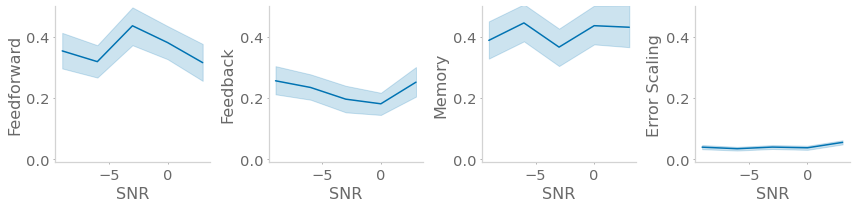

In [95]:
fig, axs = plt.subplots(1, 4, figsize = (12,3))
sns.lineplot(
    x='SNR', y='Feedforward', ax=axs[0], data=df)
sns.lineplot(
    x='SNR', y='Feedback', ax=axs[1], data=df, legend=None)
sns.lineplot(
    x='SNR', y='Memory', ax=axs[2], data=df, legend=None)
sns.lineplot(
    x='SNR', y='Error Scaling', ax=axs[3], data=df, legend=None)
for ax in axs:
    ax.set_ylim(-0.01, 0.5)
    #ax.axhline(0, color='blue', linestyle='--')
plt.tight_layout()
plt.show()

# As a function of layers, collapsed across SNR/BG

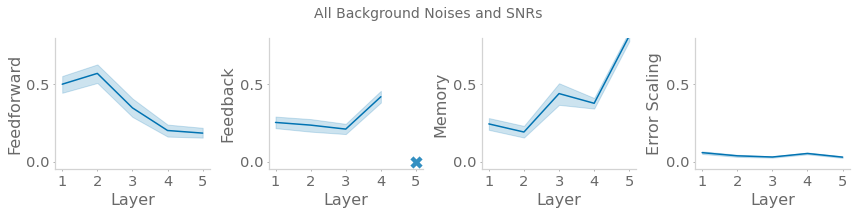

In [96]:
fig, axs = plt.subplots(1, 4, figsize = (12,3))
sns.lineplot(
    x='Layer', y='Feedforward', ax=axs[0], data=df)
sns.lineplot(
    x='Layer', y='Feedback', ax=axs[1], data=df[df['Layer']!=5],
    legend=None)
axs[1].scatter(
    5, 0., marker='X', color='C0', alpha=0.8, s=150, linewidths=0)
sns.lineplot(
    x='Layer', y='Memory', ax=axs[2], data=df, legend=None)
sns.lineplot(
    x='Layer', y='Error Scaling', ax=axs[3], data=df,
    legend=None)
for ax in axs:
    ax.set_ylim(-0.05, 0.8)
    ax.set_xticks([1,2,3,4,5])
    ax.set_yticks([0.0, 0.5])
plt.suptitle(f'All Background Noises and SNRs', fontsize=14)
plt.tight_layout()
plt.show()
print('\n\n')

# Hyperparameters, scaled by performance

In [97]:
new_df = df.copy()
for bg in np.unique(df['Background Noise']):
    for snr in np.unique(df['SNR']):
        scores = df[
            (df['Background Noise'] == bg) & (df['SNR'] == snr)
            ]['Validation Score']
        max_score = np.max(scores)
        min_score = np.min(scores)
        new_df.loc[
            (new_df['Background Noise'] == bg) & (new_df['SNR'] == snr)
            , ['Validation Score']] = (scores - min_score)/(max_score+1E-5)

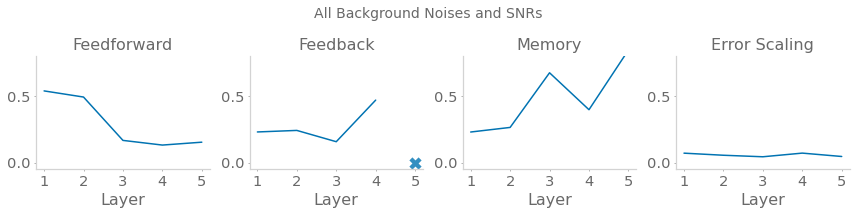

In [98]:
fig, axs = plt.subplots(1, 4, figsize = (12,3))
for hyp_idx, hyp in enumerate(['Feedforward', 'Feedback', 'Memory', 'Error Scaling']):
    layerwise_plot = []
    for layer in np.arange(1, 6):
        scores = new_df[new_df['Layer'] == layer]['Validation Score']
        hyp_vals = new_df[new_df['Layer'] == layer][hyp]
        weighted_hyp_vals = np.average(hyp_vals, weights=scores)
        if hyp == 'Feedback' and layer == 5: break
        layerwise_plot.append(weighted_hyp_vals)
    axs[hyp_idx].plot(layerwise_plot)
    axs[hyp_idx].set_title(hyp)
axs[1].scatter(4, 0., marker='X', color='C0', alpha=0.8, s=150, linewidths=0)
for ax in axs:
    ax.set_ylim(-0.05, 0.8)
    ax.set_xticks(np.arange(5), np.arange(5)+1)
    ax.set_yticks([0.0, 0.5])
    ax.set_xlabel('Layer')
plt.suptitle(f'All Background Noises and SNRs', fontsize=14)
plt.tight_layout()
plt.show()

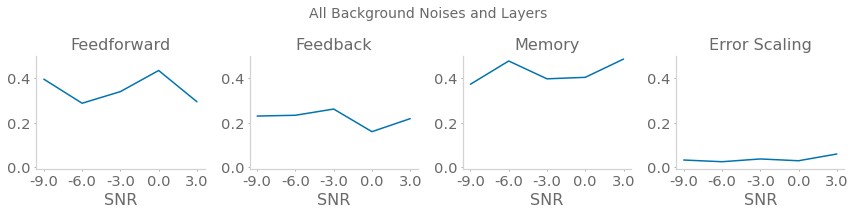

In [99]:
fig, axs = plt.subplots(1, 4, figsize = (12,3))
for hyp_idx, hyp in enumerate(['Feedforward', 'Feedback', 'Memory', 'Error Scaling']):
    layerwise_plot = []
    snr_list = [-9., -6., -3.,  0.,  3.]
    for snr in snr_list:
        scores = new_df[new_df['SNR'] == snr]['Validation Score']
        hyp_vals = new_df[new_df['SNR'] == snr][hyp]
        weighted_hyp_vals = np.average(hyp_vals, weights=scores)
        layerwise_plot.append(weighted_hyp_vals)
    axs[hyp_idx].plot(layerwise_plot)
    axs[hyp_idx].set_title(hyp)
for ax in axs:
    ax.set_ylim(-0.01, 0.5)
    ax.set_xticks(np.arange(len(snr_list)), snr_list)
    #ax.set_yticks([0.0, 0.5])
    ax.set_xlabel('SNR')
plt.suptitle(f'All Background Noises and Layers', fontsize=14)
plt.tight_layout()
plt.show()